In [372]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

In [592]:
def good_robust_redrock_redshift(data):
    search = (data['dz']<=0.0033) & (data['best_quality']>=2.5)
    search_bad = (data['dz']>0.0033) | (data['best_quality']<2.5)
    search_bad_1 = (data['dz']>0.0033) & (data['best_quality']>=2.5)
    search_bad_2 = (data['dz']<0.0033) & (data['best_quality']<2.5)
    only_good_quality = data['best_quality']>=2.5
    return data.loc[search], data.loc[search_bad],data.loc[search_bad_1],data.loc[search_bad_2],data.loc[only_good_quality]

In [584]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)
    #print(Total_good_number)
    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(SV_depth_catalog_cut)
    #print(Total_cut_number)
    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number
    Data_completeness = len(good_catalog)*1.0/Total_number

    #print('Redshift purity:', Redshift_success_rate)
    #print('Good data completeness:', Good_data_completeness)
    #print('Data completeness:', Data_completeness)
    #print('Combined value:',Redshift_success_rate*Good_data_completeness)
    return Redshift_success_rate,Good_data_completeness, Data_completeness, Total_number

In [580]:
def plot_curve(new_catalog_short,mag_bin,Cumulative):
    
    #mag_bin = [18,21.72]
    average_bin = []

    all_purity = []
    all_good_completeness = []
    all_completeness = []
    all_number = []
    
    for i in range(0,len(mag_bin)-1):
        average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
        if Cumulative==True:
            new_catalog_short_cut = new_catalog_short[(new_catalog_short['zfibermag']>=mag_bin[0]) & (new_catalog_short['zfibermag']<mag_bin[i+1])]
        else:
            new_catalog_short_cut = new_catalog_short[(new_catalog_short['zfibermag']>=mag_bin[i]) & (new_catalog_short['zfibermag']<mag_bin[i+1])]

        selected_catalog = new_catalog_short_cut[new_catalog_short_cut['DELTACHI2']>15]
        purity, good_completeness, completeness, number_point = calculate_rate(new_catalog_short_cut,selected_catalog)
        all_purity.append(purity)
        all_good_completeness.append(good_completeness)
        all_completeness.append(completeness)
        all_number.append(number_point)
    
    plt.plot(average_bin,all_purity,color='g',label='Redshift purity [Deltachi2>15]',marker='o')
    #plt.plot(average_bin,all_good_completeness,color='b',label='Good data completeness',marker='o')
    plt.plot(average_bin,all_completeness,color='r',label='Redshift completeness [Deltachi2>15]',marker='o')
    for i in range(0,len(average_bin)):
        plt.text(average_bin[i],all_completeness[i]-0.01,'%0.0f' % all_number[i])
    plt.legend(fontsize=15)
    plt.xlabel('zfibermag',fontsize=15)
    plt.axhline(0.95,ls='--',color='grey',lw=1)
    plt.axvline(21.72,ls='--',color='grey',lw=1)
    if Cumulative==True:
        plt.ylabel('Fraction (<mag)',fontsize=15)
    else:    
        plt.ylabel('Fraction',fontsize=15)

     

# The metric definitation

### *Redshift purity - what is the fraction of objects with reliable Redrock redshfits in a given selection.


### *Redshift completeness - what is the fraction of objects with reliable Redrock redshifts among the observations. 



1. Reading the cascades LRG catalog with VI

In [376]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
dataname = 'allVItiles_LRGzinfo_wVI.fits'
catalog = Table.read(diretory+dataname)
unique_catalog = catalog[(catalog['subset']=='deep') & (catalog['N_VI']>0)]
catalog = catalog[(catalog['N_VI']>0)]

# Calculating the redshift success rate for deep fields of LRGs

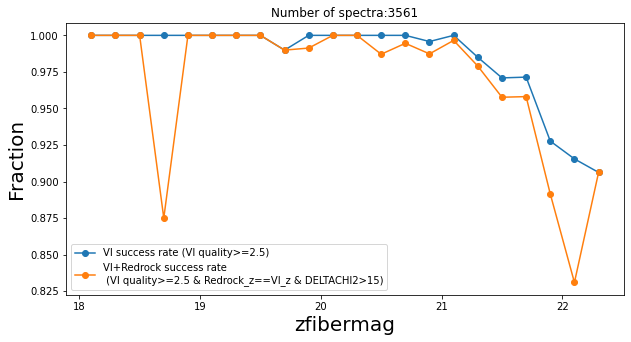

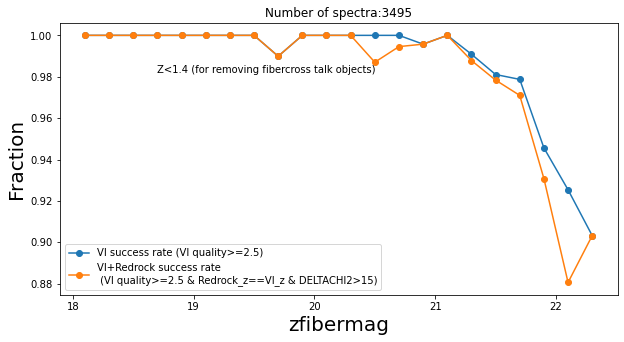

In [400]:
vi_catalog_unique = unique_catalog
zfibermag = -2.5*np.log10(vi_catalog_unique['FIBERFLUX_Z'])+22.5-1.211*vi_catalog_unique['EBV']

Cumulative = False


mag_bin = np.arange(18,22.51,0.2)
#mag_bin = [18,22.5]
average_bin = []
success_rate = []
Redrock_success_rate = []
for i in range(0,len(mag_bin)-1):
    if Cumulative==True:
        vi_catalog_unique_tmp = vi_catalog_unique[(zfibermag<mag_bin[i+1]) & (zfibermag>mag_bin[0])]
    else:
        vi_catalog_unique_tmp = vi_catalog_unique[(zfibermag<mag_bin[i+1]) & (zfibermag>mag_bin[i])]
    
    
    
    search = np.where((vi_catalog_unique_tmp['best_quality']>=2.5))# & ((vi_catalog_unique_tmp['Z']-vi_catalog_unique_tmp['best_z'])/(1+vi_catalog_unique_tmp['best_z'])<0.0033))
    #print('Redshift success rate for extra-deep field of LRGs:',len(search[0])/len(vi_catalog_unique_tmp))
    average_bin.append((mag_bin[i+1]+mag_bin[i])/2.)
 
    success_rate.append(len(search[0])/len(vi_catalog_unique_tmp))
    search = np.where((vi_catalog_unique_tmp['best_quality']>=2.5) & ((vi_catalog_unique_tmp['Z']-vi_catalog_unique_tmp['best_z'])/(1+vi_catalog_unique_tmp['best_z'])<0.0033) & (vi_catalog_unique_tmp['DELTACHI2']>15))
    Redrock_success_rate.append(len(search[0])/len(vi_catalog_unique_tmp))
plt.figure(figsize=(10,5))
plt.plot(average_bin,success_rate,label='VI success rate (VI quality>=2.5)',marker='o') 
plt.plot(average_bin,Redrock_success_rate,label='VI+Redrock success rate \n (VI quality>=2.5 & Redrock_z==VI_z & DELTACHI2>15)',marker='o') 
plt.xlabel('zfibermag',fontsize=20)
plt.title('Number of spectra:%0.0f' % len(vi_catalog_unique))
if Cumulative==True:
    plt.ylabel('Fraction (<mag)',fontsize=20)
else:
    plt.ylabel('Fraction',fontsize=20)
plt.legend()



vi_catalog_unique = unique_catalog
vi_catalog_unique = vi_catalog_unique[vi_catalog_unique['Z']<1.4]
zfibermag = -2.5*np.log10(vi_catalog_unique['FIBERFLUX_Z'])+22.5-1.211*vi_catalog_unique['EBV']
#search = np.where(zfibermag<21.)
#print(len(search[0]))
mag_bin = np.arange(18,22.51,0.2)
#mag_bin = [18,22.5]
average_bin = []
success_rate = []
Redrock_success_rate = []
for i in range(0,len(mag_bin)-1):
    if Cumulative==True:
        vi_catalog_unique_tmp = vi_catalog_unique[(zfibermag<mag_bin[i+1]) & (zfibermag>mag_bin[0])]
    else:
        vi_catalog_unique_tmp = vi_catalog_unique[(zfibermag<mag_bin[i+1]) & (zfibermag>mag_bin[i])]     
    search = np.where((vi_catalog_unique_tmp['best_quality']>=2.5))# & ((vi_catalog_unique_tmp['Z']-vi_catalog_unique_tmp['best_z'])/(1+vi_catalog_unique_tmp['best_z'])<0.0033))
    #print('Redshift success rate for extra-deep field of LRGs:',len(search[0])/len(vi_catalog_unique_tmp))
    average_bin.append((mag_bin[i+1]+mag_bin[i])/2.)
 
    success_rate.append(len(search[0])/len(vi_catalog_unique_tmp))
    search = np.where((vi_catalog_unique_tmp['best_quality']>=2.5) & ((vi_catalog_unique_tmp['Z']-vi_catalog_unique_tmp['best_z'])/(1+vi_catalog_unique_tmp['best_z'])<0.0033) & (vi_catalog_unique_tmp['DELTACHI2']>15))
    Redrock_success_rate.append(len(search[0])/len(vi_catalog_unique_tmp))
plt.figure(figsize=(10,5))
plt.plot(average_bin,success_rate,label='VI success rate (VI quality>=2.5)',marker='o') 
plt.plot(average_bin,Redrock_success_rate,label='VI+Redrock success rate \n (VI quality>=2.5 & Redrock_z==VI_z & DELTACHI2>15)',marker='o') 
plt.text(18.7,0.982,'Z<1.4 (for removing fibercross talk objects)',fontsize=10)
plt.xlabel('zfibermag',fontsize=20)
plt.title('Number of spectra:%0.0f' % len(vi_catalog_unique))
if Cumulative==True:
    plt.ylabel('Fraction (<mag)',fontsize=20)
    
else:
    plt.ylabel('Fraction',fontsize=20)
plt.legend()

In [282]:
#mag_bin

# The first part is directly using VI deep fields to check the redshift purity and completeness

1. For the SV selection

In [511]:
vi_catalog = catalog
new_catalog = vi_catalog['TARGETID','Z','ZERR','subset','TILEID','EFFTIME_DARK','DELTACHI2','FIBER','best_z','best_quality','EBV','FIBERFLUX_Z'].to_pandas()
new_catalog['dz'] = abs(new_catalog['Z']-new_catalog['best_z'])/(1.+new_catalog['best_z'])
new_catalog['zfibermag']=-2.5*np.log10(new_catalog['FIBERFLUX_Z'])+22.5-1.211*new_catalog['EBV']

new_catalog_short = new_catalog[(new_catalog['subset']!=b'all') & (new_catalog['subset']!=b'deep') &
                                (new_catalog['EFFTIME_DARK']>850) & (new_catalog['EFFTIME_DARK']<950)
                                #(new_catalog['Z']<1.4)
                                #(new_catalog['Z']<1.4) & (new_catalog['Z']>0.0)
                                ]

good_data, bad_data,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(new_catalog_short)

print('Number of short exposures:', len(new_catalog_short))
print('Number of unique targetid:',len(set(new_catalog_short['TARGETID'])))

print(len(good_data))

Number of short exposures: 8355
Number of unique targetid: 3393
7347


In [510]:
bad_data

,TARGETID,Z,ZERR,subset,TILEID,EFFTIME_DARK,DELTACHI2,FIBER,best_z,best_quality,EBV,FIBERFLUX_Z,dz,zfibermag
36,39627634556014086,0.010761,0.000086,b'00068292',80605,868.366516,2.675994,353,0.6555,4.0,0.032858,3.035687,0.389453,21.254566
111,39627634556017139,0.488303,0.000060,b'00068290',80605,922.154602,106.865803,495,2.4900,2.0,0.033071,11.751681,0.573552,19.784700
118,39627634556017139,0.488351,0.000059,b'00068292',80605,868.366516,210.264891,495,2.4900,2.0,0.033071,11.751681,0.573538,19.784700
174,39627634556019665,0.197864,0.000053,b'00068292',80605,868.366516,5.104627,491,0.9700,3.5,0.034217,1.620588,0.391947,21.934381
264,39627634560206174,0.921483,0.000085,b'00068290',80605,922.154602,0.640825,465,0.8611,3.5,0.035800,1.832746,0.032445,21.798889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98898,39627877821452222,1.021035,0.000044,b'00068337',80609,906.812744,55.115295,2671,1.1038,1.0,0.023610,2.145808,0.039341,21.642429
98899,39627877821452222,0.972376,0.000076,b'00068340',80609,852.341675,39.141109,2671,1.1038,1.0,0.023610,2.145808,0.062470,21.642429
99062,39627877825645992,0.684781,0.000094,b'00068337',80609,906.812744,3.576195,2556,0.6215,2.5,0.024481,1.382508,0.039026,22.118685
99064,39627877825645992,1.454297,0.000074,b'00068339',80609,867.040955,3.262575,2556,0.6215,2.5,0.024481,1.382508,0.513597,22.118685


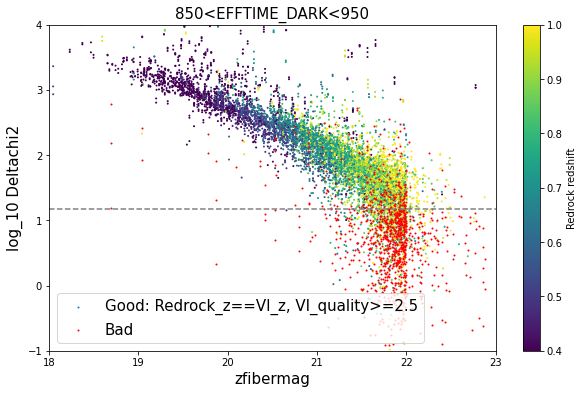

In [512]:
plt.figure(figsize=(10,6))
plt.scatter(good_data['zfibermag'],np.log10(good_data['DELTACHI2']),s=1,c=good_data['Z'],vmin=0.4,vmax=1.0,label='Good: Redrock_z==VI_z, VI_quality>=2.5')
plt.colorbar(label='Redrock redshift')
plt.scatter(bad_data['zfibermag'],np.log10(bad_data['DELTACHI2']),s=1,color='red',label='Bad',alpha=1)
plt.xlim(18,23)
plt.ylim(-1,4)
plt.legend(fontsize=15)
plt.xlabel('zfibermag',fontsize=15)
plt.ylabel('log_10 Deltachi2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)
plt.axhline(np.log10(15),ls='--',color='grey')

Text(0.5, 1.0, '850<EFFTIME_DARK<950 zfibermag<21.72')

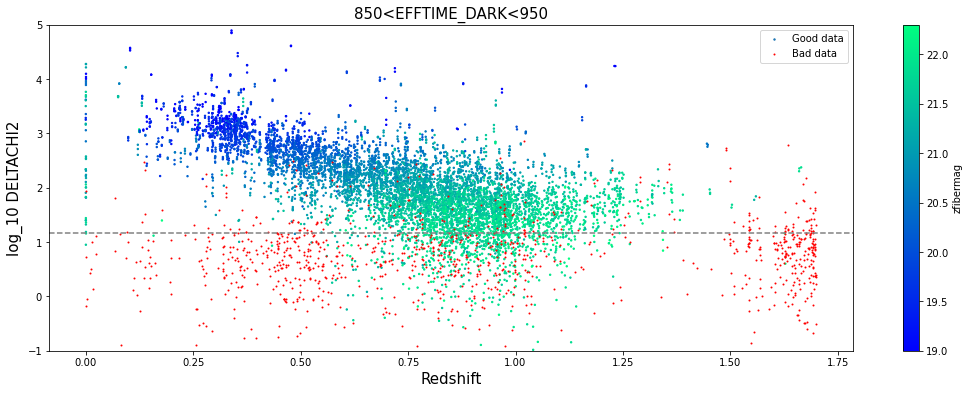

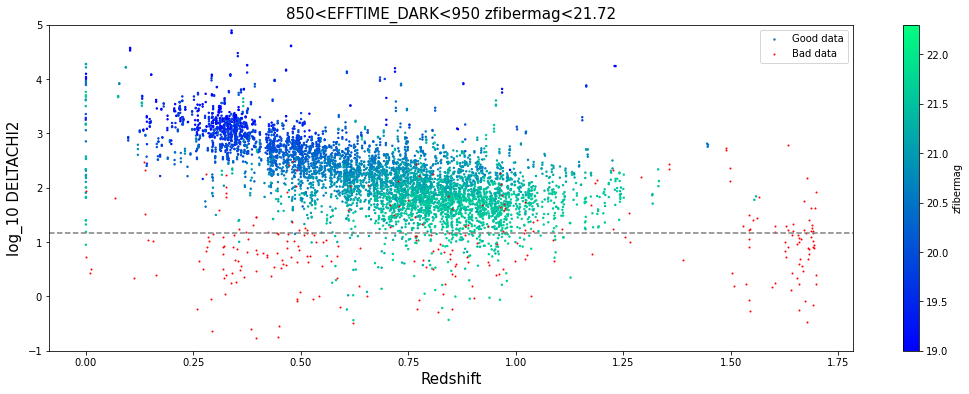

In [513]:
plt.figure(figsize=(18,6))

good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(new_catalog_short)
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2']),s=1,color='black',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)

plt.figure(figsize=(18,6))
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(new_catalog_short[new_catalog_short['zfibermag']<21.72])
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2']),s=1,color='black',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.ylim(-1,5)
#plt.xlim(0,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950 zfibermag<21.72',fontsize=15)

281


(0.3, 1.02)

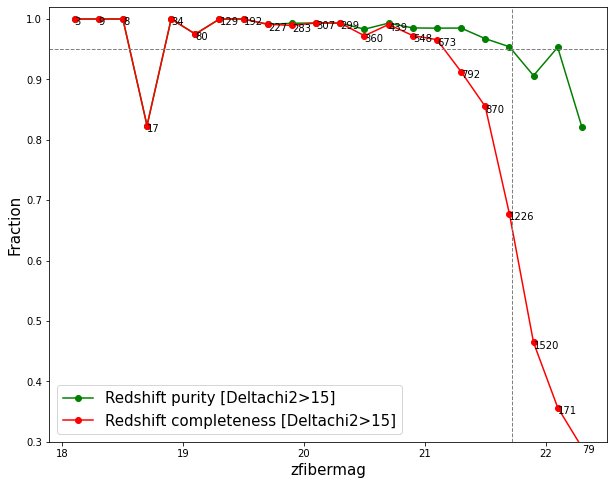

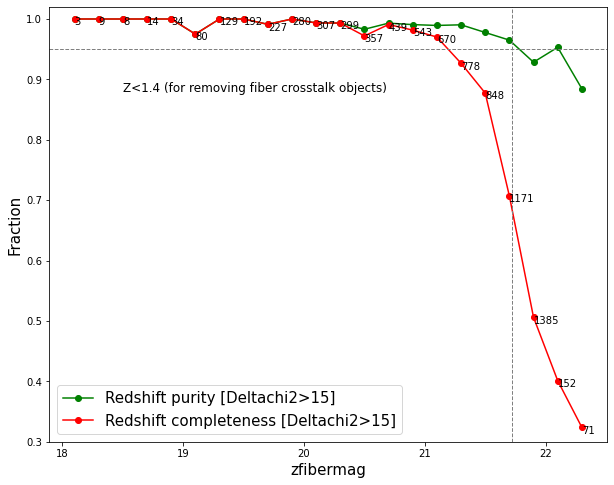

In [525]:
mag_bin = np.arange(18.,22.41,0.2)
#mag_bin = [18,21.72]
Cumulative=False
plt.figure(figsize=(10,8))
plot_curve(new_catalog_short,mag_bin,Cumulative)
plt.ylim(0.3,1.02)
plt.figure(figsize=(10,8))
print(len(new_catalog_short[(new_catalog_short['Z']>1.4)]))
plot_curve(new_catalog_short[(new_catalog_short['Z']<1.4)],mag_bin,Cumulative)
plt.text(18.5,0.88,'Z<1.4 (for removing fiber crosstalk objects)',fontsize=12)
plt.ylim(0.3,1.02)
#plt.yscale('log')

281


(0.75, 1.02)

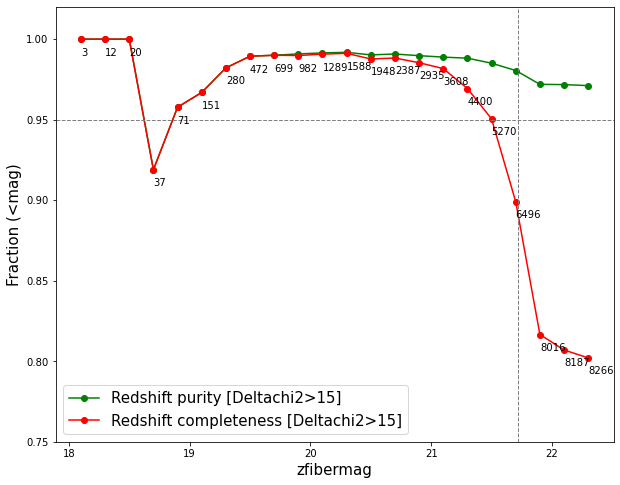

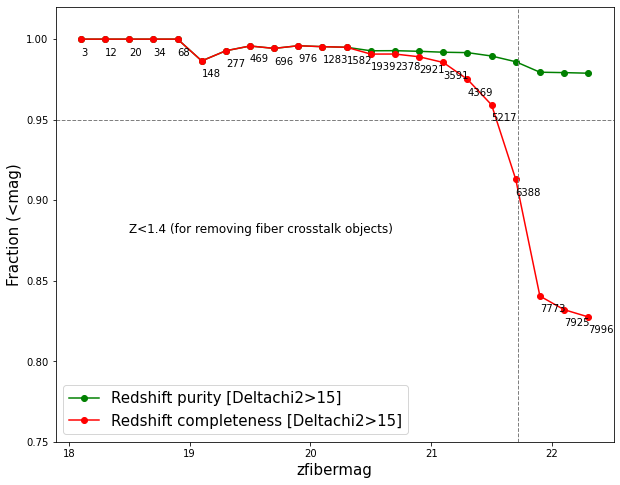

In [527]:
mag_bin = np.arange(18.,22.41,0.2)
#mag_bin = [18,21.72]
Cumulative=True
plt.figure(figsize=(10,8))
plot_curve(new_catalog_short,mag_bin,Cumulative)
plt.ylim(0.75,1.02)
plt.figure(figsize=(10,8))
print(len(new_catalog_short[(new_catalog_short['Z']>1.4)]))
plot_curve(new_catalog_short[(new_catalog_short['Z']<1.4)],mag_bin,Cumulative)
plt.text(18.5,0.88,'Z<1.4 (for removing fiber crosstalk objects)',fontsize=12)
plt.ylim(0.75,1.02)
#plt.yscale('log')

In [531]:
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(new_catalog_short[(new_catalog_short['DELTACHI2']>15)])
mag_bin = np.arange(18.,22.51,0.5)
good['dv']=(good['Z']-good['best_z'])/(1+good['best_z'])*300000
mean_dv = []
std_dv = []
average_bin = []
N = []
for i in range(0,len(mag_bin)-1):
    tmp_good = good[(good['zfibermag']>=mag_bin[i]) & (good['zfibermag']<mag_bin[i+1])]
    N.append(len(tmp_good))
    mean_dv.append(np.mean(tmp_good['dv']))
    std_dv.append(np.std(tmp_good['dv']))
    average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
    

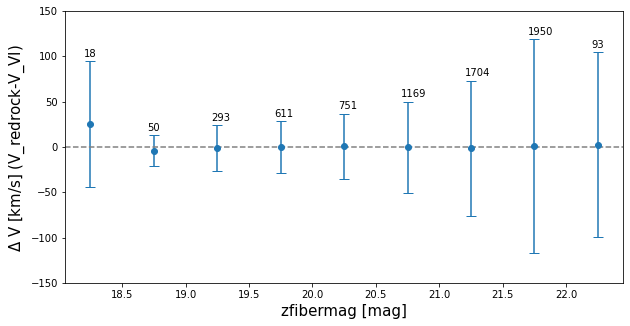

In [537]:
plt.figure(figsize=(10,5))
plt.errorbar(average_bin,mean_dv,std_dv,ls='',marker='o',capsize=5)
for i in range(0,len(N)):
    plt.text(average_bin[i]-0.05,mean_dv[i]+std_dv[i]+5,'%0.0f' % N[i],fontsize=10)
plt.ylim(-150,150)
plt.ylabel('$\\Delta$ V [km/s] (V_redrock-V_VI) ',fontsize=15)
plt.xlabel('zfibermag [mag]',fontsize=15)
plt.axhline(0.0,ls='--',color='grey')

# Using the whole SV catalog to do the analysis

In [538]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
dataname = 'alltiles_LRGzinfo.fits'
all_catalog = Table.read(diretory+dataname)

In [539]:
search_deep = np.where((all_catalog['subset']!='all')  & 
                            (all_catalog['subset']=='deep') & 
                            (all_catalog['EFFTIME_DARK']>3000) &
                        (all_catalog['TARGETS']!='BGS+MWS'))
catalog_LRG = all_catalog[search_deep[0]].copy()
print('Number of deep exposures:', len(catalog_LRG))
#print(len(set(catalog_LRG['TARGETID'])))

Number of deep exposures: 24973


In [540]:
zfibermag = -2.5*np.log10(catalog_LRG['FIBERFLUX_Z'])+22.5-1.211*catalog_LRG['EBV']


2. Selecting the short exposures coadds with EFFTIME_dark>700 (not deep or all)

In [541]:
search_LRG_short = np.where((all_catalog['subset']!='all') & (all_catalog['subset']!='deep') & (all_catalog['TARGETS']!='BGS+MWS') & 
                            (all_catalog['EFFTIME_DARK']>850) & (all_catalog['EFFTIME_DARK']<950))
catalog_LRG_short = all_catalog[search_LRG_short[0]].copy()
print('Number of short exposures:', len(catalog_LRG_short))

Number of short exposures: 26045


In [566]:
new_catalog_LRG_short = catalog_LRG_short[['TARGETID','Z','ZERR','subset','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN','FIBER','RZR']].to_pandas()
new_catalog_LRG = catalog_LRG['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_DARK','FIBERFLUX_Z','EBV','ZWARN','FIBER','RZR'].to_pandas()
new_catalog_LRG['zfibermag']=-2.5*np.log10(new_catalog_LRG['FIBERFLUX_Z'])+22.5-1.211*new_catalog_LRG['EBV']
new_catalog_LRG['best_z']=new_catalog_LRG['Z']
new_catalog_LRG['best_quality']=0
new_catalog_LRG['best_quality'][(new_catalog_LRG['best_z']<1.4)  & (new_catalog_LRG['DELTACHI2']>15)]=4

In [567]:
#plt.scatter(new_catalog_LRG['best_quality'],np.log10(new_catalog_LRG['DELTACHI2']),s=1)

(array([ 288.,  509.,  739., 1126., 1529., 2197., 2959., 3398., 3224.,
        2939., 2358., 1722., 1248.,  592.,  356.,  192.,  107.,   59.,
          26.,   12.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

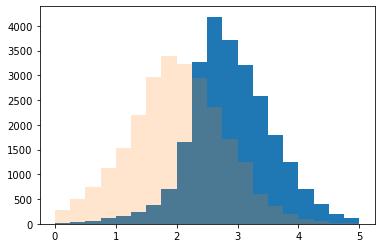

In [568]:
plt.hist(np.log10(new_catalog_LRG['DELTACHI2']),bins=20,range=(0,5))
plt.hist(np.log10(new_catalog_LRG_short['DELTACHI2']),bins=20,range=(0,5),alpha=0.2)

## Key assumption: We assume that for LRGs with z<1.4 and with DELTACHI2>15 with EFFTIME_dark>3000, the Redrock redshifts are the true redshifts. 

In [569]:
catalog_LRG_match = new_catalog_LRG_short.merge(new_catalog_LRG,on='TARGETID',how='left',suffixes=("","_deep"))
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_deep']==catalog_LRG_match['TILEID']]
final_match_catalog['dz']=abs(final_match_catalog['best_z']-final_match_catalog['Z'])/(1.+final_match_catalog['best_z'])

(array([ 276.,  482.,  704., 1069., 1454., 2085., 2838., 3249., 3089.,
        2821., 2238., 1634., 1185.,  544.,  326.,  176.,  101.,   52.,
          23.,   11.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

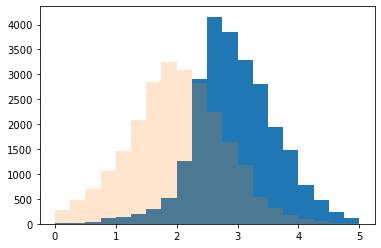

In [570]:
plt.hist(np.log10(final_match_catalog['DELTACHI2_deep']),bins=20,range=(0,5))
plt.hist(np.log10(final_match_catalog['DELTACHI2']),bins=20,range=(0,5),alpha=0.2)

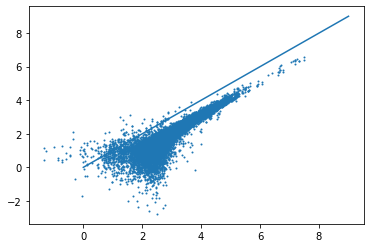

In [571]:
plt.scatter(np.log10(final_match_catalog['DELTACHI2_deep']),np.log10(final_match_catalog['DELTACHI2']),s=1)
plt.plot(np.arange(0,10),np.arange(0,10))

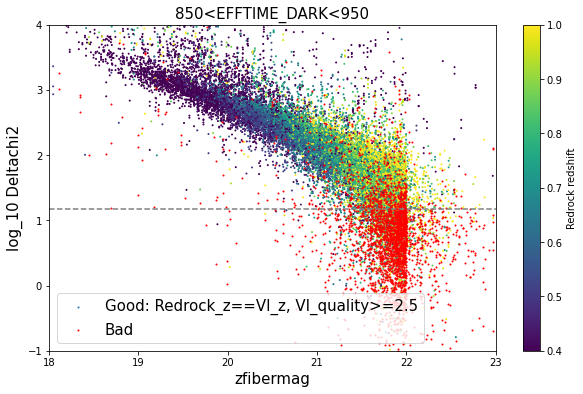

In [572]:
good_data, bad_data,bad_1,bad_2,good_quality_data = good_robust_redrock_redshift(final_match_catalog)

plt.figure(figsize=(10,6))
plt.scatter(good_data['zfibermag'],np.log10(good_data['DELTACHI2']),s=1,c=good_data['Z'],vmin=0.4,vmax=1.0,label='Good: Redrock_z==VI_z, VI_quality>=2.5')
plt.colorbar(label='Redrock redshift')
plt.scatter(bad_data['zfibermag'],np.log10(bad_data['DELTACHI2']),s=1,color='red',label='Bad',alpha=1)
plt.xlim(18,23)
plt.ylim(-1,4)
plt.legend(fontsize=15)
plt.xlabel('zfibermag',fontsize=15)
plt.ylabel('log_10 Deltachi2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)
plt.axhline(np.log10(15),ls='--',color='grey')

Text(0.5, 1.0, '850<EFFTIME_DARK<950 zfibermag<21.72')

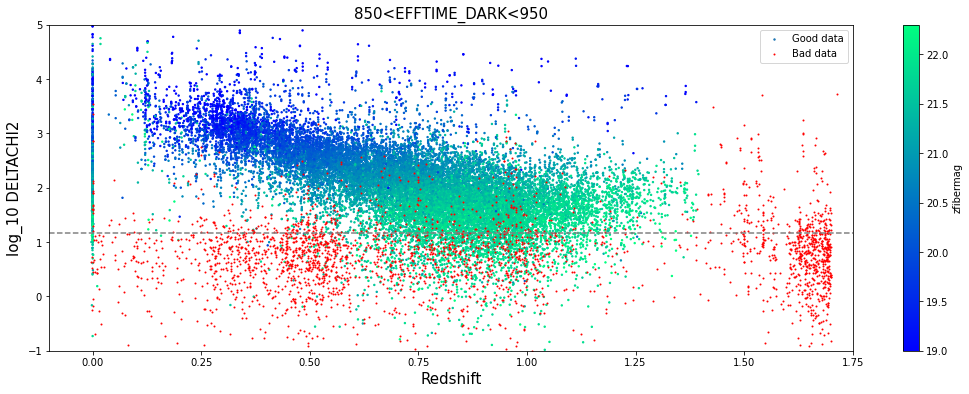

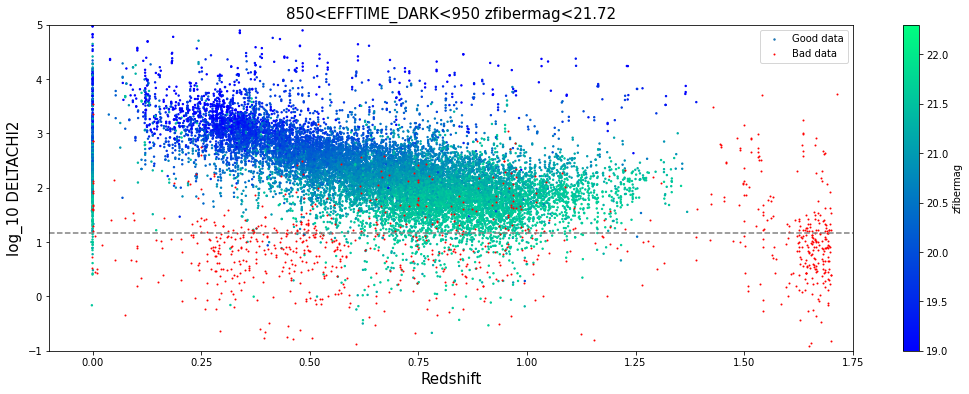

In [573]:
plt.figure(figsize=(18,6))

good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(final_match_catalog)
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.xlim(-0.1,1.75)
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950',fontsize=15)

plt.figure(figsize=(18,6))
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(final_match_catalog[final_match_catalog['zfibermag']<21.72])
plt.scatter(good['Z'],np.log10(good['DELTACHI2']),s=2,c=good['zfibermag'],vmin=19,vmax=22.3,cmap=cm.winter,label='Good data')
plt.colorbar(label='zfibermag')
plt.scatter(bad['Z'],np.log10(bad['DELTACHI2']),s=1,color='r',label='Bad data')
plt.axhline(np.log10(15),ls='--',color='grey')
plt.legend()
plt.xlim(-0.1,1.75)
plt.ylim(-1,5)
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('log_10 DELTACHI2',fontsize=15)
plt.title('850<EFFTIME_DARK<950 zfibermag<21.72',fontsize=15)

24800
24010


(0.3, 1.02)

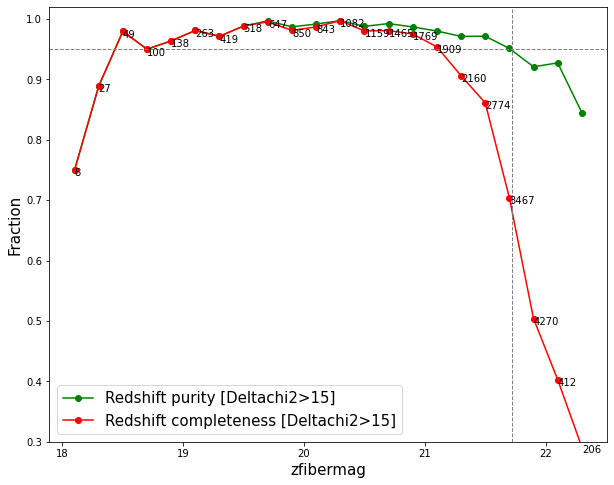

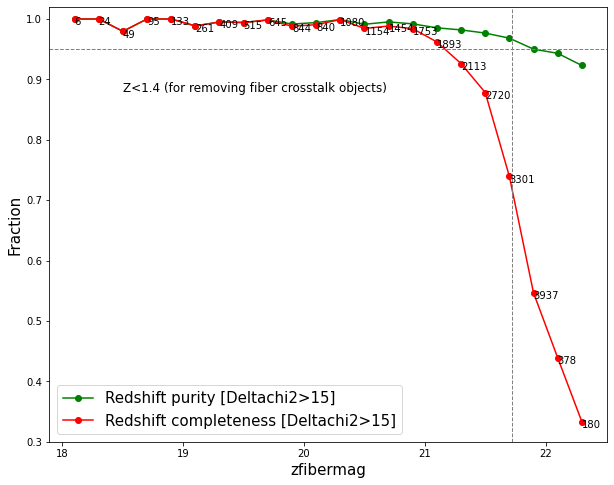

In [585]:
mag_bin = np.arange(18.,22.5,0.2)
#mag_bin = [18.,21.72]
Cumulative = False
plt.figure(figsize=(10,8))
plot_curve(final_match_catalog,mag_bin,Cumulative)
plt.ylim(0.3,1.02)
print(len(final_match_catalog))
print(len(final_match_catalog[(final_match_catalog['Z']<1.4)]))
plt.figure(figsize=(10,8))
plot_curve(final_match_catalog[(final_match_catalog['Z']<1.4)],mag_bin,Cumulative)
plt.text(18.5,0.88,'Z<1.4 (for removing fiber crosstalk objects)',fontsize=12)
plt.ylim(0.3,1.02)

24800
24010


(0.75, 1.02)

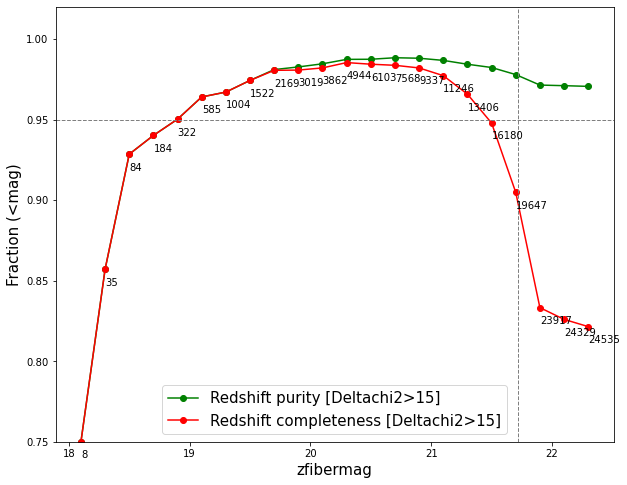

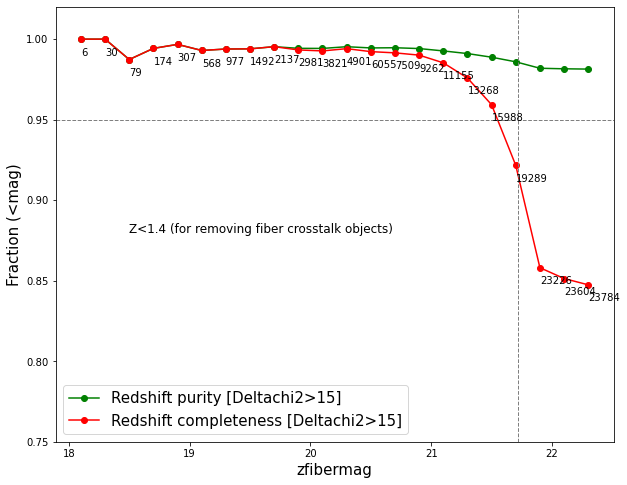

In [586]:
Cumulative = True
plt.figure(figsize=(10,8))
plot_curve(final_match_catalog,mag_bin,Cumulative)
plt.ylim(0.75,1.02)
print(len(final_match_catalog))
print(len(final_match_catalog[(final_match_catalog['Z']<1.4)]))
plt.figure(figsize=(10,8))
plot_curve(final_match_catalog[(final_match_catalog['Z']<1.4)],mag_bin,Cumulative)
plt.text(18.5,0.88,'Z<1.4 (for removing fiber crosstalk objects)',fontsize=12)
plt.ylim(0.75,1.02)

In [587]:
good, bad, bad_1, bad_2, good_only_quality = good_robust_redrock_redshift(final_match_catalog[(final_match_catalog['zfibermag']<22.5) & (final_match_catalog['DELTACHI2']>15)])

In [590]:
mag_bin = np.arange(18.,22.51,0.5)
good['dv']=(good['Z']-good['best_z'])/(1+good['best_z'])*300000
mean_dv = []
mean_stddv = []
std_dv = []
average_bin = []
N = []
for i in range(0,len(mag_bin)-1):
    tmp_good = good[(good['zfibermag']>=mag_bin[i]) & (good['zfibermag']<mag_bin[i+1])]
    N.append(len(tmp_good))
    mean_dv.append(np.mean(tmp_good['dv']))
    mean_stddv.append(np.mean(tmp_good['ZERR']/(1+tmp_good['Z'])*300000))
    std_dv.append(np.std(tmp_good['dv']))
    average_bin.append((mag_bin[i]+mag_bin[i+1])/2.)
    

Text(0.5, 0, 'zfibermag [mag]')

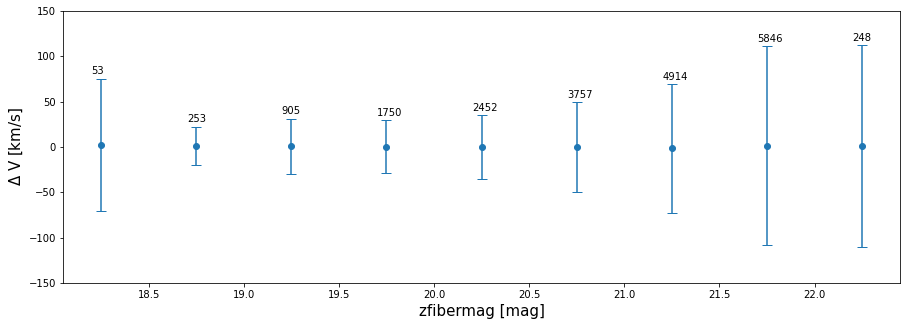

In [591]:
plt.figure(figsize=(15,5))
plt.errorbar(average_bin,mean_dv,std_dv,ls='',marker='o',capsize=5)
for i in range(0,len(N)):
    plt.text(average_bin[i]-0.05,mean_dv[i]+std_dv[i]+5,'%0.0f' % N[i],fontsize=10)
plt.ylim(-150,150)
plt.ylabel('$\\Delta$ V [km/s]',fontsize=15)
plt.xlabel('zfibermag [mag]',fontsize=15)